# NOAA Wave Watch 3 and NDBC Buoy Data Comparison

*Note: this notebook requires python3.*

This notebook demostrates how to compare [WaveWatch III Global Ocean Wave Model](http://data.planetos.com/datasets/noaa_ww3_global_1.25x1d:noaa-wave-watch-iii-nww3-ocean-wave-model?utm_source=github&utm_medium=notebook&utm_campaign=ndbc-wavewatch-iii-notebook) and [NOAA NDBC buoy data](http://data.planetos.com/datasets/noaa_ndbc_stdmet_stations?utm_source=github&utm_medium=notebook&utm_campaign=ndbc-wavewatch-iii-notebook) using the Planet OS API.

API documentation is available at http://docs.planetos.com. If you have questions or comments, join the [Planet OS Slack community](http://slack.planetos.com/) to chat with our development team.


For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/. This notebook also makes use of the [matplotlib basemap toolkit.](http://matplotlib.org/basemap/index.html)

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
from urllib.request import urlopen, Request
import simplejson as json
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap

**Important!** You'll need to replace apikey below with your actual Planet OS API key, which you'll find [on the Planet OS account settings page.](#http://data.planetos.com/account/settings/?utm_source=github&utm_medium=notebook&utm_campaign=ww3-api-notebook) and NDBC buoy station name in which you are intrested.

In [5]:
dataset_id = 'noaa_ndbc_stdmet_stations'
## stations with wave height available: '46006', '46013', '46029'
## stations without wave height: icac1', '41047', 'bepb6', '32st0', '51004'
## stations too close to coastline (no point to compare to ww3)'sacv4', 'gelo1', 'hcef1'
station = '46029'
apikey = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'

Let's first query the API to see what stations are available for the [NDBC Standard Meteorological Data dataset.](http://data.planetos.com/datasets/noaa_ndbc_stdmet_stations?utm_source=github&utm_medium=notebook&utm_campaign=ndbc-wavewatch-iii-notebook)

In [6]:
API_url = 'http://api.planetos.com/v1/datasets/%s/stations?apikey=%s' % (dataset_id, apikey)
request = Request(API_url)
response = urlopen(request)
API_data_locations = json.loads(response.read())
# print(API_data_locations)

Now we'll use matplotlib to visualize the stations on a simple basemap.

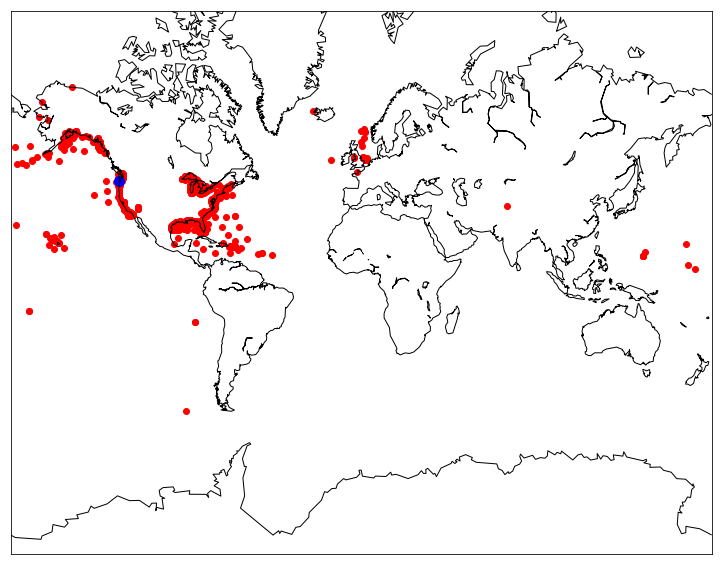

In [7]:
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
fig=plt.figure(figsize=(15,10))
m.drawcoastlines()
##m.fillcontinents()
for i in API_data_locations['station']:
    x,y=m(API_data_locations['station'][i]['SpatialExtent']['coordinates'][0],
          API_data_locations['station'][i]['SpatialExtent']['coordinates'][1])
    plt.scatter(x,y,color='r')
x,y=m(API_data_locations['station'][station]['SpatialExtent']['coordinates'][0],
          API_data_locations['station'][station]['SpatialExtent']['coordinates'][1])
plt.scatter(x,y,s=100,color='b')

Let's examine the last five days of data. For the WaveWatch III forecast, we'll use the reference time parameter to pull forecast data from the 18:00 model run from five days ago.

In [8]:
## Find suitable reference time values
atthemoment = datetime.utcnow()
atthemoment = atthemoment.strftime('%Y-%m-%dT%H:%M:%S') 

before5days = datetime.utcnow() - timedelta(days=5)
before5days_long = before5days.strftime('%Y-%m-%dT%H:%M:%S')
before5days_short = before5days.strftime('%Y-%m-%d')

start = before5days_long
end = atthemoment

reftime_start = str(before5days_short) + 'T18:00:00'
reftime_end = reftime_start

API request for NOAA NDBC buoy station data

In [9]:
API_url = "http://api.planetos.com/v1/datasets/{0}/point?station={1}&apikey={2}&start={3}&end={4}&count=1000".format(dataset_id,station,apikey,start,end)
print(API_url)

http://api.planetos.com/v1/datasets/noaa_ndbc_stdmet_stations/point?station=46029&apikey=8428878e4b944abeb84790e832c633fc&start=2018-06-30T08:33:58&end=2018-07-05T08:33:58&count=1000


In [10]:
request = Request(API_url)
response = urlopen(request)
API_data_buoy = json.loads(response.read())

In [11]:
buoy_variables = []
for k,v in set([(j,i['context']) for i in API_data_buoy['entries'] for j in i['data'].keys()]):
    buoy_variables.append(k)

Find buoy station coordinates to use them later for finding NOAA Wave Watch III data

In [12]:
for i in API_data_buoy['entries']:
    #print(i['axes']['time'])
    if i['context'] == 'time_latitude_longitude':
        longitude = (i['axes']['longitude'])
        latitude = (i['axes']['latitude'])

print ('Latitude: '+ str(latitude))
print ('Longitude: '+ str(longitude))


Latitude: 46.159000396728516
Longitude: -124.51399993896484


API request for NOAA WaveWatch III (NWW3) Ocean Wave Model near the point of selected station. Note that data may not be available at the requested reference time. If the response is empty, try removing the reference time parameters `reftime_start` and `reftime_end` from the query.

In [13]:
API_url = 'http://api.planetos.com/v1/datasets/noaa_ww3_global_1.25x1d/point?lat={0}&lon={1}&verbose=true&apikey={2}&count=100&end={3}&reftime_start={4}&reftime_end={5}'.format(latitude,longitude,apikey,end,reftime_start,reftime_end)
request = Request(API_url)
response = urlopen(request)
API_data_ww3 = json.loads(response.read())
print(API_url)

http://api.planetos.com/v1/datasets/noaa_ww3_global_1.25x1d/point?lat=46.159000396728516&lon=-124.51399993896484&verbose=true&apikey=8428878e4b944abeb84790e832c633fc&count=100&end=2018-07-05T08:33:58&reftime_start=2018-06-30T18:00:00&reftime_end=2018-06-30T18:00:00


In [14]:
ww3_variables = []
for k,v in set([(j,i['context']) for i in API_data_ww3['entries'] for j in i['data'].keys()]):
    ww3_variables.append(k)

Manually review the list of WaveWatch and NDBC data variables to determine which parameters are equivalent for comparison.

In [15]:
print(ww3_variables)
print(buoy_variables)

['Wind_speed_surface', 'v-component_of_wind_surface', 'u-component_of_wind_surface', 'Primary_wave_direction_surface', 'Significant_height_of_combined_wind_waves_and_swell_surface', 'Significant_height_of_swell_waves_ordered_sequence_of_data', 'Mean_period_of_swell_waves_ordered_sequence_of_data', 'Mean_period_of_wind_waves_surface', 'Direction_of_swell_waves_ordered_sequence_of_data', 'Primary_wave_mean_period_surface', 'Secondary_wave_direction_surface', 'Secondary_wave_mean_period_surface', 'Wind_direction_from_which_blowing_surface', 'Direction_of_wind_waves_surface', 'Significant_height_of_wind_waves_surface']
['wind_spd', 'wave_height', 'air_temperature', 'dewpt_temperature', 'mean_wave_dir', 'average_wpd', 'dominant_wpd', 'sea_surface_temperature', 'air_pressure', 'wind_dir', 'water_level', 'visibility', 'gust']


Next we'll build a dictionary of corresponding variables that we want to compare.

In [16]:
buoy_model = {'wave_height':'Significant_height_of_combined_wind_waves_and_swell_surface',
              'mean_wave_dir':'Primary_wave_direction_surface',
             'average_wpd':'Primary_wave_mean_period_surface',
             'wind_spd':'Wind_speed_surface'}

Read data from the JSON responses and convert the values to floats for plotting. Note that depending on the dataset, some variables have different timesteps than others, so a separate time array for each variable is recommended.

In [17]:
def append_data(in_string):
    if in_string == None:
        return np.nan
    elif in_string == 'None':
        return np.nan
    else:
        return float(in_string)

ww3_data = {}
ww3_times = {}
buoy_data = {}
buoy_times = {}
for k,v in buoy_model.items():
    ww3_data[v] = []
    ww3_times[v] = []
    buoy_data[k] = []
    buoy_times[k] = []

for i in API_data_ww3['entries']:
    for j in i['data']:
        if j in buoy_model.values():
            ww3_data[j].append(append_data(i['data'][j]))
            ww3_times[j].append(dateutil.parser.parse(i['axes']['time']))
            
for i in API_data_buoy['entries']:
    for j in i['data']:
        if j in buoy_model.keys():
            buoy_data[j].append(append_data(i['data'][j]))
            buoy_times[j].append(dateutil.parser.parse(i['axes']['time']))
for i in ww3_data:
    ww3_data[i] = np.array(ww3_data[i])
    ww3_times[i] = np.array(ww3_times[i])

Finally, let's plot the data using matplotlib.

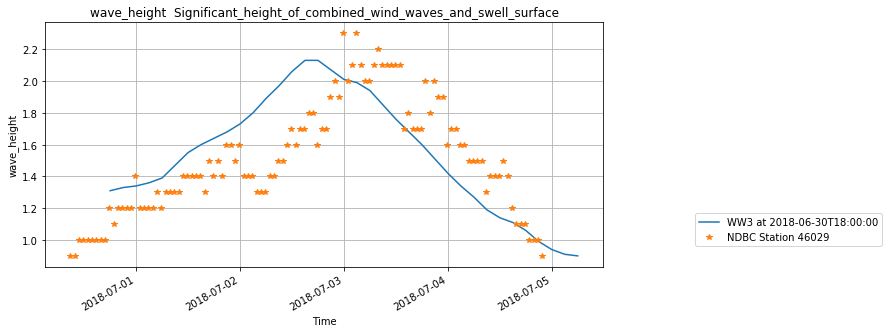

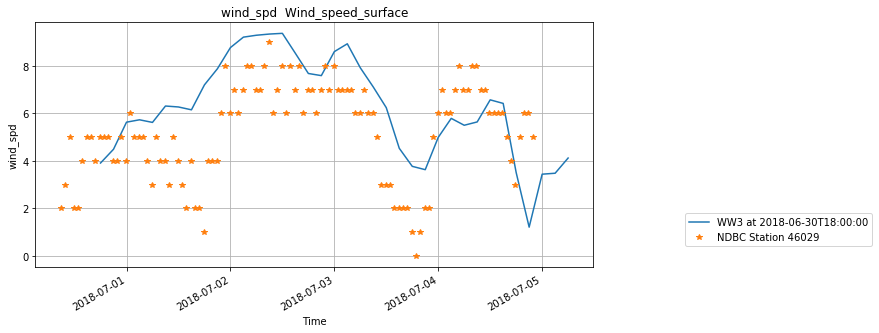

In [18]:
buoy_label = "NDBC Station %s" % station
ww3_label = "WW3 at %s" % reftime_start
for k,v in buoy_model.items():
    if np.abs(np.nansum(buoy_data[k]))>0:
        fig=plt.figure(figsize=(10,5))
        plt.title(k+'  '+v)
        plt.plot(ww3_times[v],ww3_data[v], label=ww3_label)
        plt.plot(buoy_times[k],buoy_data[k],'*',label=buoy_label)
        plt.legend(bbox_to_anchor=(1.5, 0.22), loc=1, borderaxespad=0.)
        plt.xlabel('Time')
        plt.ylabel(k)
        fig.autofmt_xdate()
        plt.grid()